<a href="https://colab.research.google.com/github/Islam-elrefaei/Time-Series-Forecasting-/blob/main/Thesis_TimeSeries_Trade_Off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Read Data From Drive path
path= "/content/drive/MyDrive/Time_Series_Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Dataset 1 - DISCOUNT RATE




# SARIMAX from Statsmodels

- **Statsmodels** is a Python library that provides a wide range of statistical models and tools for data analysis. It is built on top of NumPy, SciPy, and Pandas, and offers functionalities for statistical modeling, estimation, hypothesis testing, and more. One of the key components of Statsmodels is the tsa module, which focuses on time series analysis.

- Within the **tsa** module, Statsmodels provides the SARIMAX class, which stands for Seasonal Autoregressive Integrated Moving Average with eXogenous regressors. SARIMAX is an extension of the popular ARIMA (Autoregressive Integrated Moving Average) model, capable of handling time series data with seasonal patterns.

- **SARIMAX** allows you to model and forecast time series by incorporating autoregressive (AR), differencing (I), moving average (MA), and seasonal (S) components. The model parameters, denoted as (p, d, q) × (P, D, Q, s), represent the orders of the AR, I, MA, and seasonal components, respectively.

- **Here's a breakdown of the parameters in SARIMAX:**

    - p: The order of the autoregressive component, representing the number of lagged observations to include in the model.
    - d: The order of differencing, indicating the number of times the series needs to be differenced to achieve stationarity.
    - q: The order of the moving average component, representing the number of lagged forecast errors to include in the model.
    - P: The order of the seasonal autoregressive component.
    - D: The order of seasonal differencing.
    - Q: The order of the seasonal moving average component.
    - s: The length of the seasonal cycle (e.g., 12 for monthly data with yearly seasonality).

In [ ]:
# Load the dataset
df = pd.read_csv(path+"/data.csv", sep="|")

# Convert 'VALID_FROM' column to datetime format
df['VALID_FROM'] = pd.to_datetime(df['VALID_FROM'], format='%Y%m%d')

df

,VALID_FROM,CNB_DISCOUNT_RATE_IN_%
0,1990-01-01,4.00
1,1990-04-01,5.00
2,1990-10-01,7.00
3,1990-11-11,8.50
4,1991-01-01,10.00
...,...,...
61,2021-12-23,2.75
62,2022-02-04,3.50
63,2022-04-01,4.00
64,2022-05-06,4.75


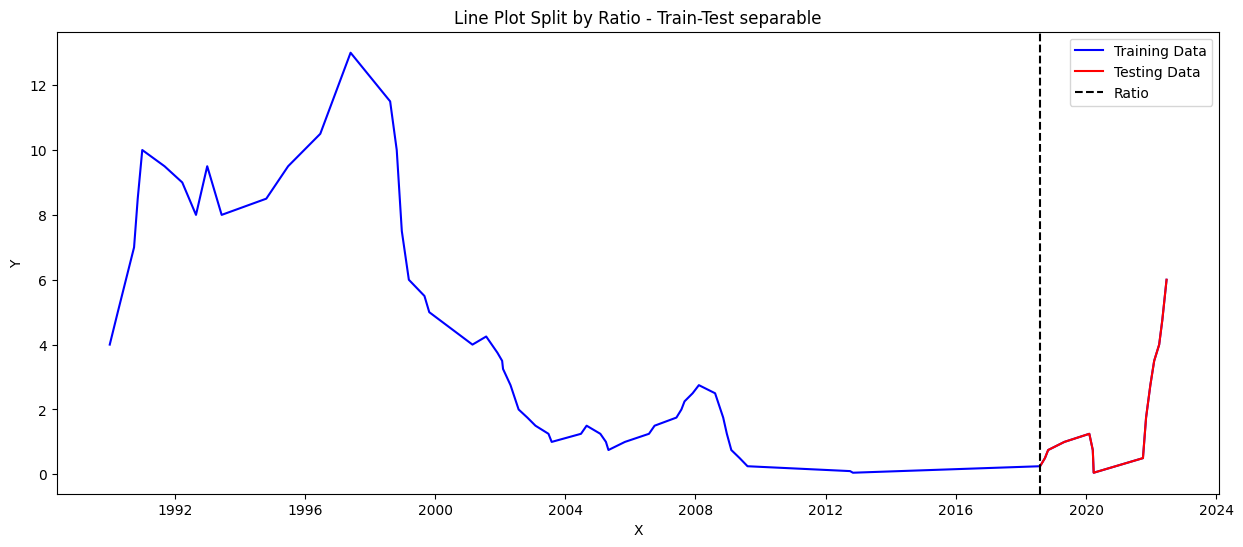

In [ ]:
# Generate some random data
x = df['VALID_FROM']
y = df["CNB_DISCOUNT_RATE_IN_%"]

# Define the ratio point (where to split the plot)
ratio = 0.8

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the entire line
ax.plot(x, y, color='blue', label='Training Data')

# Set the x-axis limit for the vertical line
x_limit = x[int(ratio * len(x))]

# Plot the first part of the line in one color
#ax.plot(x[:int(ratio * len(x))], y[:int(ratio * len(y))], color='green', label='Part 1')

# Plot the second part of the line in another color
ax.plot(x[int(ratio * len(x)):], y[int(ratio * len(y)):], color='red', label='Testing Data')

# Add a vertical line to separate the parts
ax.axvline(x=x_limit, color='black', linestyle='--', label='Ratio')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line Plot Split by Ratio - Train-Test separable')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Set 'VALID_FROM' column as the index
df = df.set_index('VALID_FROM')

# Sort the dataframe by index (date)
df = df.sort_index()

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train_data = df[:train_size]
test_data = df[train_size:]

df

,CNB_DISCOUNT_RATE_IN_%
VALID_FROM,
1990-01-01,4.00
1990-04-01,5.00
1990-10-01,7.00
1990-11-11,8.50
1991-01-01,10.00
...,...
2021-12-23,2.75
2022-02-04,3.50
2022-04-01,4.00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


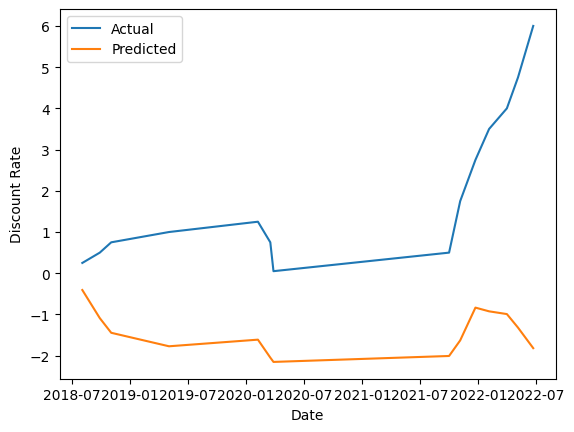

Evaluation Metrics:
Mean Absolute Error (MAE): 3.42
Mean Squared Error (MSE): 14.95
Root Mean Squared Error (RMSE): 3.87


In [ ]:
# Create and train the SARIMA model
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit()

# Perform predictions on the test set
predictions = result.predict(start=len(train_data), end=len(df)-1)

# Visualize the actual values vs. predicted values
plt.plot(test_data.index, test_data['CNB_DISCOUNT_RATE_IN_%'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Discount Rate')
plt.legend()
plt.show()

# Evaluate the model
mae_1_1 = mean_absolute_error(test_data['CNB_DISCOUNT_RATE_IN_%'], predictions)
mse_1_1 = mean_squared_error(test_data['CNB_DISCOUNT_RATE_IN_%'], predictions)
rmse_1_1 = mean_squared_error(test_data['CNB_DISCOUNT_RATE_IN_%'], predictions, squared=False)

# Display evaluation metrics
print('Evaluation Metrics:')
print(f'Mean Absolute Error (MAE): {mae_1_1:.2f}')
print(f'Mean Squared Error (MSE): {mse_1_1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_1_1:.2f}')


<hr>

#  Prophet - Facebook's model for Time Series Forecasting

- Prophet is a time series forecasting model developed by Facebook's Core Data Science team. It is designed to handle a wide range of time series forecasting tasks, including those with irregular patterns, trends, seasonality, and holiday effects. Prophet combines the flexibility of additive decomposition models with the power of Bayesian inference to provide accurate and interpretable forecasts.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1o2zq5i/19ter41g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1o2zq5i/w8vk12rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56892', 'data', 'file=/tmp/tmpn1o2zq5i/19ter41g.json', 'init=/tmp/tmpn1o2zq5i/w8vk12rt.json', 'output', 'file=/tmp/tmpn1o2zq5i/prophet_modelynwe9fg0/prophet_model-20230513191832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


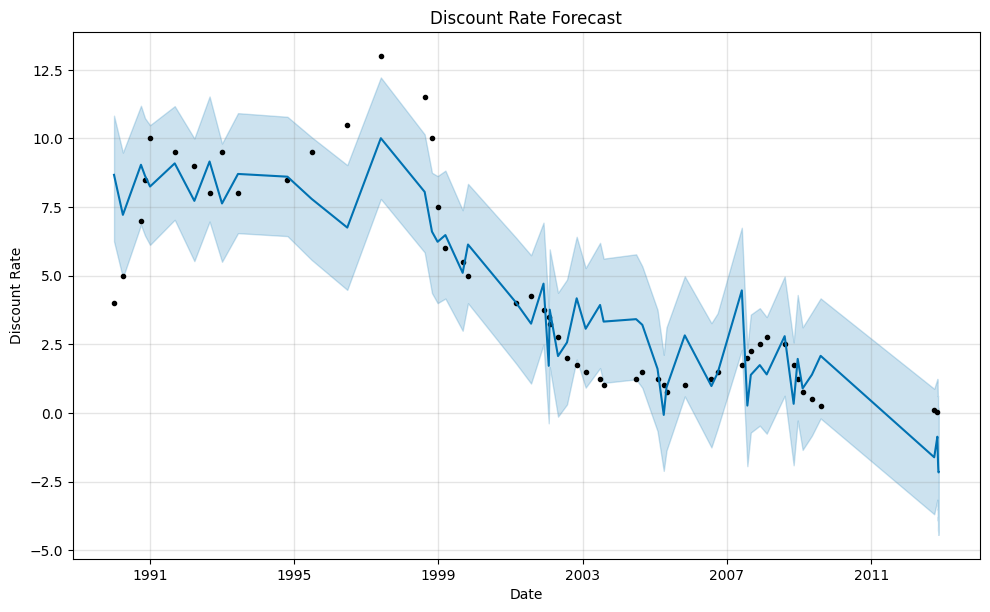

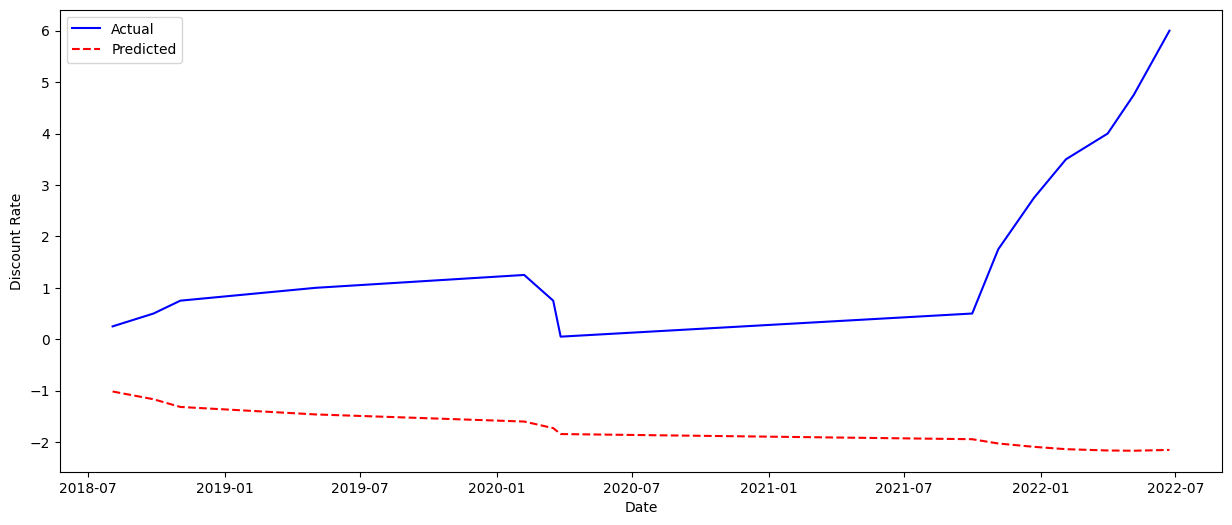

Evaluation Metrics:
Mean Absolute Error (MAE): 3.76
Mean Squared Error (MSE): 18.60
Root Mean Squared Error (RMSE): 4.31


In [ ]:
# Load the dataset
df = pd.read_csv(path+"/data.csv", sep="|")

# Convert 'VALID_FROM' column to datetime format
df['VALID_FROM'] = pd.to_datetime(df['VALID_FROM'], format='%Y%m%d')

# Set 'VALID_FROM' column as the index
df = df.set_index('VALID_FROM')

# Sort the dataframe by index (date)
df = df.sort_index()

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train_data = df[:train_size]
test_data = df[train_size:]


# Prepare the data for Prophet
train_data_prophet = train_data.reset_index()
train_data_prophet.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(train_data_prophet)

# Forecast on the test set
future = model.make_future_dataframe(periods=len(test_data))
forecast = model.predict(future)

# Extract the predicted values
predictions = forecast['yhat'][train_size:]


# Visualize the forecast
model.plot(forecast, xlabel='Date', ylabel='Discount Rate')
plt.title('Discount Rate Forecast')
plt.show()

plt.figure(figsize=(15,6))
# Visualize the actual values vs. predicted values
plt.plot(test_data.index, test_data['CNB_DISCOUNT_RATE_IN_%'], color='blue', linestyle='-', label='Actual')
plt.plot(test_data.index, predictions, color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Discount Rate')
plt.legend()
plt.show()

# Evaluate the model
mae_1_2 = mean_absolute_error(test_data['CNB_DISCOUNT_RATE_IN_%'], predictions)
mse_1_2 = mean_squared_error(test_data['CNB_DISCOUNT_RATE_IN_%'], predictions)
rmse_1_2 = mean_squared_error(test_data['CNB_DISCOUNT_RATE_IN_%'], predictions, squared=False)

# Display evaluation metrics
print('Evaluation Metrics:')
print(f'Mean Absolute Error (MAE): {mae_1_2:.2f}')
print(f'Mean Squared Error (MSE): {mse_1_2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_1_2:.2f}')


<hr>

# LSTM - Deep learning for Time series Forecasting

- LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that has gained popularity for time series forecasting tasks. It is a deep learning model designed to capture long-term dependencies and patterns in sequential data, making it well-suited for analyzing and predicting time series.

- LSTM models are particularly effective when dealing with time series data that exhibit complex temporal dependencies, non-linear relationships, and variable-length sequences. They can capture patterns such as trends, seasonality, and irregularities in the data.

Epoch 1/10
51/51 - 9s - loss: 0.1313 - val_loss: 0.0167 - 9s/epoch - 178ms/step
Epoch 2/10
51/51 - 0s - loss: 0.0519 - val_loss: 0.0294 - 449ms/epoch - 9ms/step
Epoch 3/10
51/51 - 0s - loss: 0.0335 - val_loss: 0.0180 - 404ms/epoch - 8ms/step
Epoch 4/10
51/51 - 1s - loss: 0.0207 - val_loss: 0.0124 - 625ms/epoch - 12ms/step
Epoch 5/10
51/51 - 1s - loss: 0.0113 - val_loss: 0.0048 - 716ms/epoch - 14ms/step
Epoch 6/10
51/51 - 1s - loss: 0.0074 - val_loss: 0.0039 - 632ms/epoch - 12ms/step
Epoch 7/10
51/51 - 1s - loss: 0.0082 - val_loss: 0.0045 - 541ms/epoch - 11ms/step
Epoch 8/10
51/51 - 1s - loss: 0.0077 - val_loss: 0.0035 - 712ms/epoch - 14ms/step
Epoch 9/10
51/51 - 1s - loss: 0.0079 - val_loss: 0.0054 - 564ms/epoch - 11ms/step
Epoch 10/10
51/51 - 1s - loss: 0.0064 - val_loss: 0.0037 - 501ms/epoch - 10ms/step
1/1 [==============================] - 0s 26ms/step


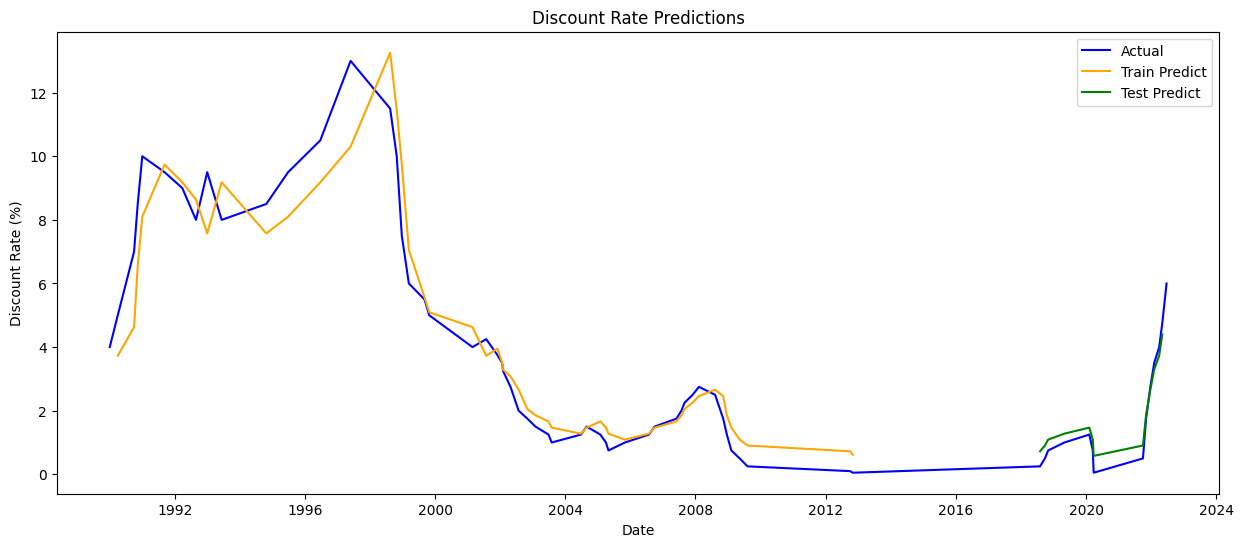

In [ ]:
# Read the data
df = pd.read_csv(path+'/data.csv', sep='|')
df.columns = ['date', 'discount_rate']
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.set_index('date', inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df.values.reshape(-1, 1))

# Split into train/test
train_size = int(len(scaled_values) * 0.8)
train, test = scaled_values[0:train_size,:], scaled_values[train_size:len(scaled_values),:]

# Reshape into X=t and Y=t+1
X_train, Y_train = [], []
for i in range(len(train)-1):
    X_train.append(train[i])
    Y_train.append(train[i+1])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_test, Y_test = [], []
for i in range(len(test)-1):
    X_test.append(test[i])
    Y_test.append(test[i+1])
X_test, Y_test = np.array(X_test), np.array(Y_test)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Plot predictions
train_predict_plot = np.empty_like(scaled_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[1:len(train_predict)+1, :] = train_predict

test_predict_plot = np.empty_like(scaled_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+1:len(scaled_values)-1, :] = test_predict

# Inverse scaling
train_predict_plot = scaler.inverse_transform(train_predict_plot)
test_predict_plot = scaler.inverse_transform(test_predict_plot)

plt.figure(figsize=(15,6))
# Plot the results
plt.plot(df.index, df['discount_rate'], 'b', label='Actual')
plt.plot(df.index, train_predict_plot, 'orange', label='Train Predict')
plt.plot(df.index, test_predict_plot, 'green', label='Test Predict')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Discount Rate (%)')
plt.title('Discount Rate Predictions')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Inverse scaling
y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Remove the last element from train_predict and test_predict
train_predict = train_predict[:-1]
test_predict = test_predict[:-1]

# Calculate MSE
train_mse = mean_squared_error(y_train[:-1], train_predict)
mse_1_3 = mean_squared_error(y_test[:-1], test_predict)

# Calculate RMSE
train_rmse = math.sqrt(train_mse)
rmse_1_3 = math.sqrt(mse_1_3)

# Calculate MAE
train_mae = mean_absolute_error(y_train[:-1], train_predict)
mae_1_3 = mean_absolute_error(y_test[:-1], test_predict)

#print("Train MSE:", train_mse)
print("Test MSE:", mse_1_3)
#print("Train RMSE:", train_rmse)
print("Test RMSE:", rmse_1_3)
#print("Train MAE:", train_mae)
print("Test MAE:", mae_1_3)


Test MSE: 0.4533803426218304
Test RMSE: 0.6733352379178075
Test MAE: 0.5531002342700959


In [ ]:
import pandas as pd

# Define the index, column names, and values
columns = ['MSE', 'RMSE', 'MAE']
index = ['SARIMAX', 'Prophet', 'LSTM']
values = [[mse_1_1, rmse_1_1, mae_1_1], [mse_1_2, rmse_1_2, mae_1_2], [mse_1_3, rmse_1_3, mae_1_3]]

# Create the DataFrame
df = pd.DataFrame(values, index=index, columns=columns)

# Define a function to apply styles to specific cells
def style_cells(value):
    style = 'background-color: red' if value > 4 else  'background-color: green'
    return style

# Apply the style to the DataFrame
styled_df = df.style.applymap(style_cells)

# Add lines to the DataFrame
styled_df.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
])

# Display the styled DataFrame
print("The Evaluation trade-off for the First Dataset : ")
styled_df


The Evaluation trade-off for the First Dataset : 


,MSE,RMSE,MAE
SARIMAX,14.949495,3.866458,3.417446
Prophet,18.600330,4.312810,3.759066
LSTM,0.453380,0.673335,0.553100


<hr>

# 2. Dataset 2 - Number of accidents

In [ ]:
df2 = pd.read_excel(path+"/nehody.xlsx", header=4)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')
df2

,Date,number of accidents
0,2006-01-01,499
1,2006-01-02,492
2,2006-01-03,571
3,2006-01-04,535
4,2006-01-05,518
...,...,...
6294,2023-03-27,237
6295,2023-03-28,303
6296,2023-03-29,237
6297,2023-03-30,237


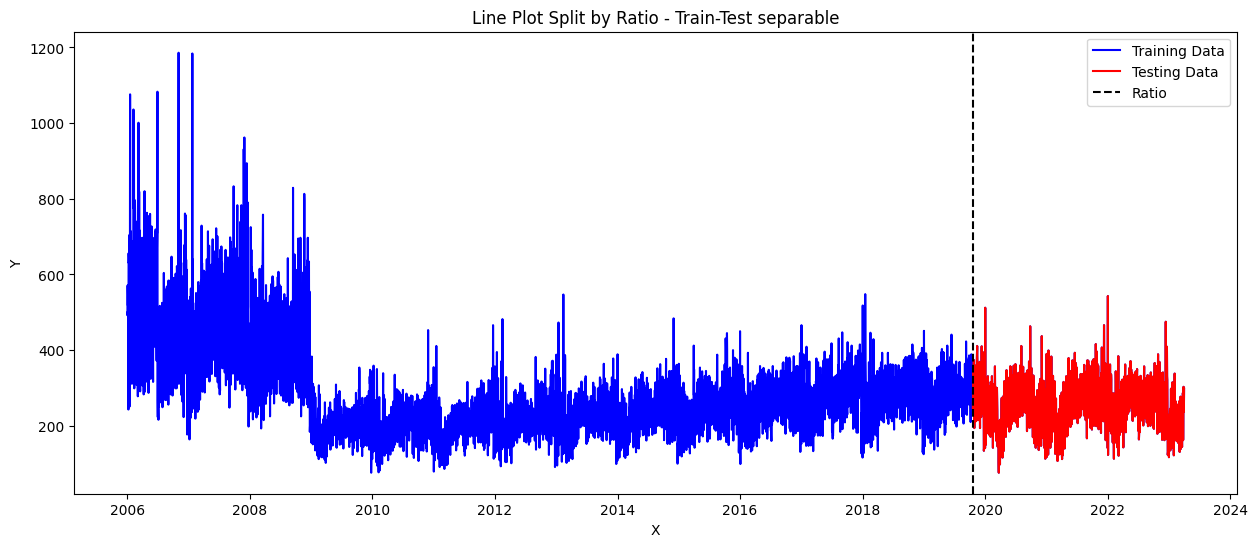

In [ ]:
# Generate some random data
x = df2['Date']
y = df2["number of accidents"]

# Define the ratio point (where to split the plot)
ratio = 0.8

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the entire line
ax.plot(x, y, color='blue', label='Training Data')

# Set the x-axis limit for the vertical line
x_limit = x[int(ratio * len(x))]

# Plot the first part of the line in one color
#ax.plot(x[:int(ratio * len(x))], y[:int(ratio * len(y))], color='green', label='Part 1')

# Plot the second part of the line in another color
ax.plot(x[int(ratio * len(x)):], y[int(ratio * len(y)):], color='red', label='Testing Data')

# Add a vertical line to separate the parts
ax.axvline(x=x_limit, color='black', linestyle='--', label='Ratio')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line Plot Split by Ratio - Train-Test separable')

# Add legend
ax.legend()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


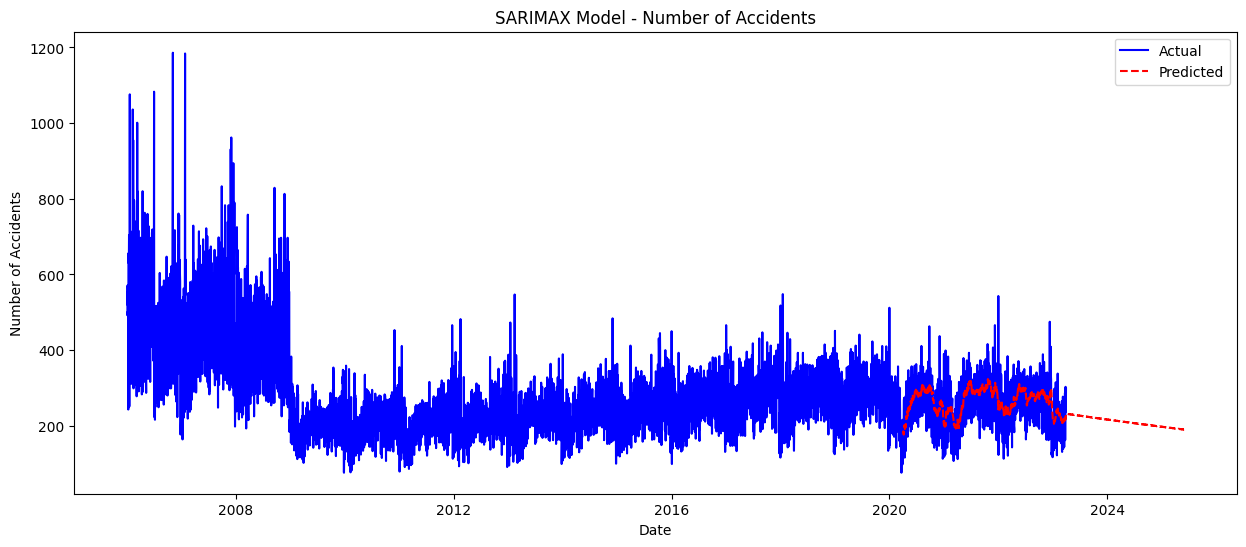

In [ ]:
df2.set_index('Date', inplace=True)

# Time series Model 1
model = SARIMAX(df2, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()
predictions = model_fit.predict(start=pd.to_datetime('2020-04-01'), end=pd.to_datetime('2025-05-31'))

plt.figure(figsize=(15,6))
# Plot the actual values and predicted values
plt.plot(df2.index, df2['number of accidents'], label='Actual', color='blue')
plt.plot(predictions.index, predictions, label='Predicted', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.title('SARIMAX Model - Number of Accidents')
plt.legend()
plt.show()


In [ ]:
# Make in-sample predictions
predictions = model_fit.get_prediction(start=pd.to_datetime('2006-01-01'), end=pd.to_datetime('2023-03-31'))
predicted_values = predictions.predicted_mean

actual_values = df2['number of accidents']
mse_2_1 = ((predicted_values - actual_values) ** 2).mean()
rmse_2_1 = mse_2_1 ** 0.5
mae_2_1 = mean_absolute_error(actual_values, predicted_values)

print("Evaluation with statsmodels SARIMAX:")
print("MSE:", mse_2_1)
print("RMSE:", rmse_2_1)
print("MAE:", mae_2_1)

Evaluation with statsmodels SARIMAX:
MSE: 5813.758535727205
RMSE: 76.24800676560145
MAE: 54.86572001295856


# model2

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1o2zq5i/syalil3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1o2zq5i/vyr1zfq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23111', 'data', 'file=/tmp/tmpn1o2zq5i/syalil3k.json', 'init=/tmp/tmpn1o2zq5i/vyr1zfq_.json', 'output', 'file=/tmp/tmpn1o2zq5i/prophet_model66o6ks4j/prophet_model-20230513191913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


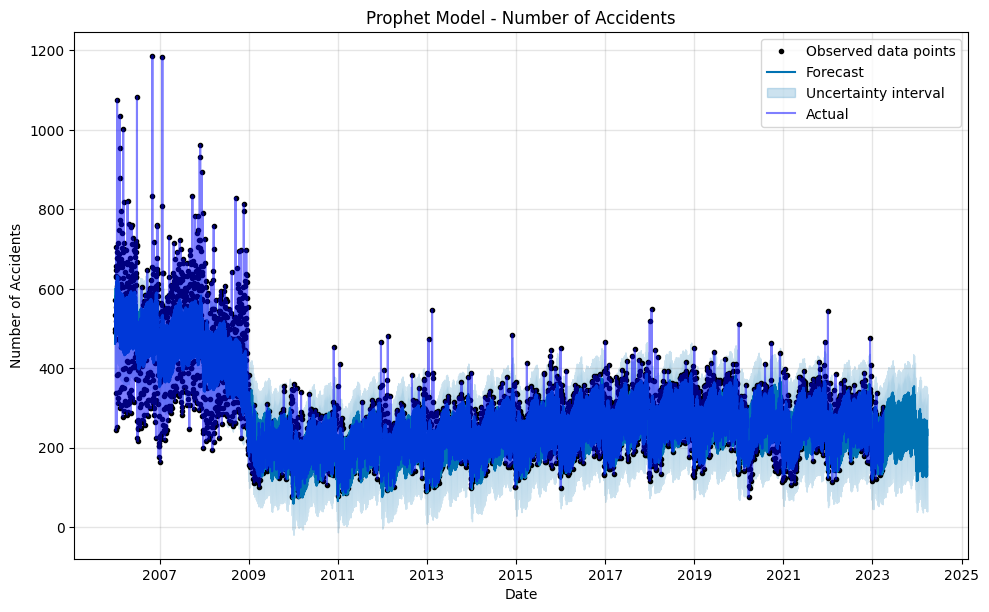

In [ ]:
df2 = pd.read_excel(path+"/nehody.xlsx", header=4)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')
df2.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(df2)

# Generate future dates for prediction
future_dates = model.make_future_dataframe(periods=361)  # Predict for 61 days (May and June 2023)

# Make predictions
predictions = model.predict(future_dates)

# Plot the actual values and predicted values
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(predictions, ax=ax)
ax.plot(df2['ds'], df2['y'], label='Actual', color='blue', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Accidents')
ax.set_title('Prophet Model - Number of Accidents')
ax.legend()
plt.show()

In [ ]:
# Make predictions
predictions = model.predict(future_dates)
predicted_values = predictions['yhat'][:-361]  # Keep only in-sample predictions

# Calculate evaluation metrics
actual_values = df2['y']
mse_2_2 = ((predicted_values - actual_values) ** 2).mean()
rmse_2_2 = mse_2_2 ** 0.5
mae_2_2 = mean_absolute_error(actual_values, predicted_values)

print("Evaluation with Prophet:")
print("MSE:", mse_2_2)
print("RMSE:", rmse_2_2)
print("MAE:", mae_2_2)

Evaluation with Prophet:
MSE: 3530.4347664888087
RMSE: 59.41746179776454
MAE: 39.1229759207423


# Model3

In [ ]:
# Load the dataset
df2 = pd.read_excel(path+"/nehody.xlsx", header=4)
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df2.values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create the training data sequences
def create_sequences(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

# Define the number of time steps
time_steps = 7

# Create the training sequences
X_train, Y_train = create_sequences(train_data, time_steps)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=5, batch_size=1, verbose=2)

# Predict on the test data
inputs = df2[-len(test_data)-time_steps:].values.reshape(-1, 1)
inputs = scaler.transform(inputs)
X_test, Y_test = create_sequences(inputs, time_steps)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Calculate evaluation metrics
mse_2_3 = mean_squared_error(df2[-len(test_data):].values[:len(predicted)], predicted)
rmse_2_3 = np.sqrt(mse_2_3)
mae_2_3 = mean_absolute_error(df2[-len(test_data):].values[:len(predicted)], predicted)

print("Evaluation with LSTM:")
print("MSE:", mse_2_3)
print("RMSE:", rmse_2_3)
print("MAE:", mae_2_3)

<ipython-input-18-9a619dba00a8>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2['Date'] = pd.to_datetime(df2['Date'])


Epoch 1/5
5031/5031 - 24s - loss: 0.0056 - 24s/epoch - 5ms/step
Epoch 2/5
5031/5031 - 20s - loss: 0.0042 - 20s/epoch - 4ms/step
Epoch 3/5
5031/5031 - 21s - loss: 0.0039 - 21s/epoch - 4ms/step
Epoch 4/5
5031/5031 - 22s - loss: 0.0037 - 22s/epoch - 4ms/step
Epoch 5/5
5031/5031 - 21s - loss: 0.0036 - 21s/epoch - 4ms/step
40/40 [==============================] - 1s 2ms/step
Evaluation with LSTM:
MSE: 2507.3932161182847
RMSE: 50.07387758221132
MAE: 37.64613781020791


In [ ]:
import pandas as pd

# Define the index, column names, and values
columns = ['MSE', 'RMSE', 'MAE']
index = ['SARIMAX', 'Prophet', 'LSTM']
values = [[mse_2_1, rmse_2_1, mae_2_1], [mse_2_2, rmse_2_2, mae_2_2], [mse_2_3, rmse_2_3, mae_2_3]]

# Create the DataFrame
df = pd.DataFrame(values, index=index, columns=columns)

# Define a function to apply styles to specific cells
def style_cells(value):
    style = 'background-color: red' if value > 50 else  'background-color: green'
    return style

# Apply the style to the DataFrame
styled_df = df.style.applymap(style_cells)

# Add lines to the DataFrame
styled_df.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
])

# Display the styled DataFrame
print("The Evaluation trade-off for the Second Dataset : ")
styled_df


The Evaluation trade-off for the Second Dataset : 


,MSE,RMSE,MAE
SARIMAX,5813.758536,76.248007,54.865720
Prophet,3530.434766,59.417462,39.122976
LSTM,2507.393216,50.073878,37.646138


<hr>

# Dataset3 - Yahoo Finance

- The ticker symbol **AAPL**" is commonly used to represent Apple Inc. in financial markets, including stock exchanges. Ticker symbols are unique identifiers assigned to publicly traded companies to facilitate trading and tracking their stock prices.

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fetching data from Yahoo Finance
yf.pdr_override()
symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2022-12-31"
df3 = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
df3

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496293,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507525,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392176,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434674,447610800
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674026,85438400


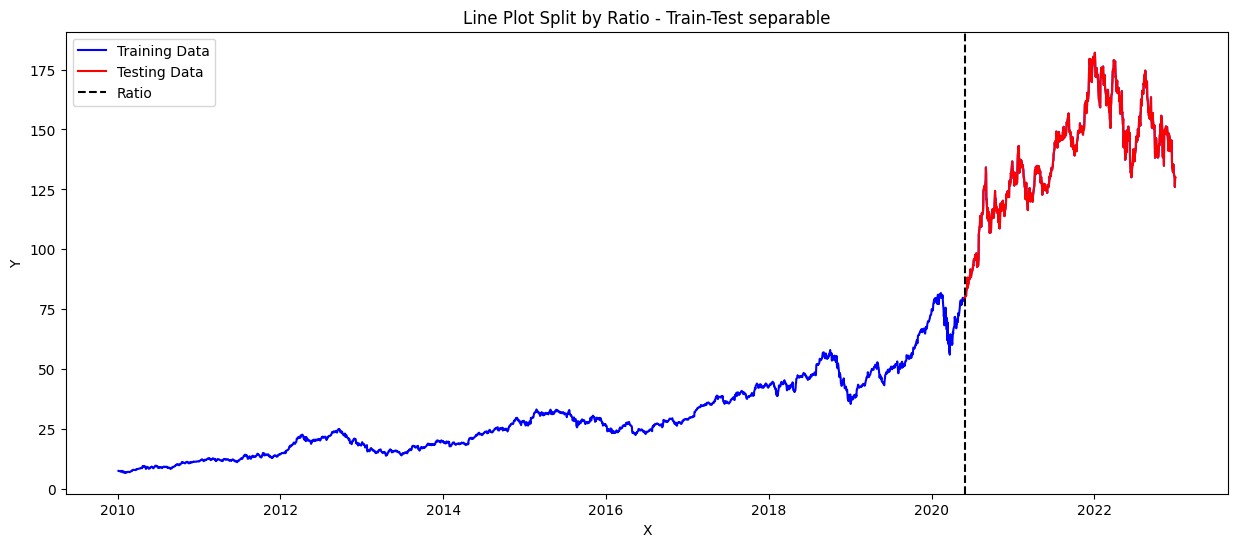

In [ ]:
# Generate some random data
x = df3.index
y = df3["Close"]

# Define the ratio point (where to split the plot)
ratio = 0.8

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the entire line
ax.plot(x, y, color='blue', label='Training Data')

# Set the x-axis limit for the vertical line
x_limit = x[int(ratio * len(x))]

# Plot the first part of the line in one color
#ax.plot(x[:int(ratio * len(x))], y[:int(ratio * len(y))], color='green', label='Part 1')

# Plot the second part of the line in another color
ax.plot(x[int(ratio * len(x)):], y[int(ratio * len(y)):], color='red', label='Testing Data')

# Add a vertical line to separate the parts
ax.axvline(x=x_limit, color='black', linestyle='--', label='Ratio')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line Plot Split by Ratio - Train-Test separable')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Preparing the data
ts_data = df3[["Close"]]
ts_data

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


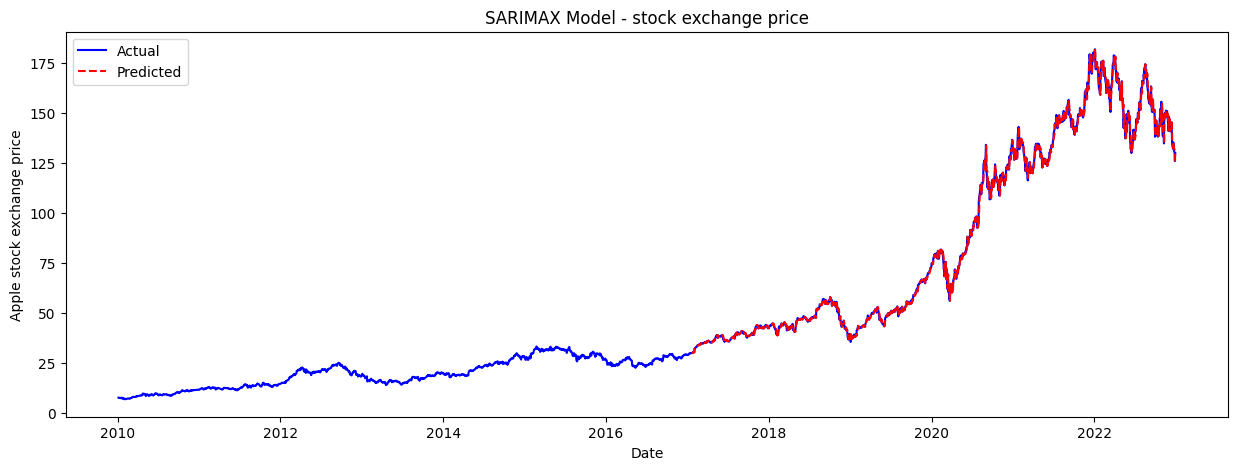

Evaluation with SARIMAX Model:
MSE: 4.180719426742125
RMSE: 2.04468076401724
MAE: 1.2963073722570477


In [ ]:
# Time series Model 1
model = SARIMAX(ts_data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()
predictions = model_fit.predict(start=pd.to_datetime('2017-01-20'), end=pd.to_datetime('2022-12-30'))


plt.figure(figsize=(15,5))
# Plot the actual values and predicted values
plt.plot(ts_data.index, ts_data['Close'], label='Actual', color='blue')
plt.plot(predictions.index, predictions, label='Predicted', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Apple stock exchange price')
plt.title('SARIMAX Model - stock exchange price')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse_3_1 = mean_squared_error(ts_data['Close'].loc['2017-01-20':'2022-12-30'], predictions)
rmse_3_1 = np.sqrt(mse_3_1)
mae_3_1 = mean_absolute_error(ts_data['Close'].loc['2017-01-20':'2022-12-30'], predictions)

print("Evaluation with SARIMAX Model:")
print("MSE:", mse_3_1)
print("RMSE:", rmse_3_1)
print("MAE:", mae_3_1)

# Model2 - Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1o2zq5i/9ril6t6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1o2zq5i/1yt3xs45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88538', 'data', 'file=/tmp/tmpn1o2zq5i/9ril6t6a.json', 'init=/tmp/tmpn1o2zq5i/1yt3xs45.json', 'output', 'file=/tmp/tmpn1o2zq5i/prophet_modelqv1jot5q/prophet_model-20230513192155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


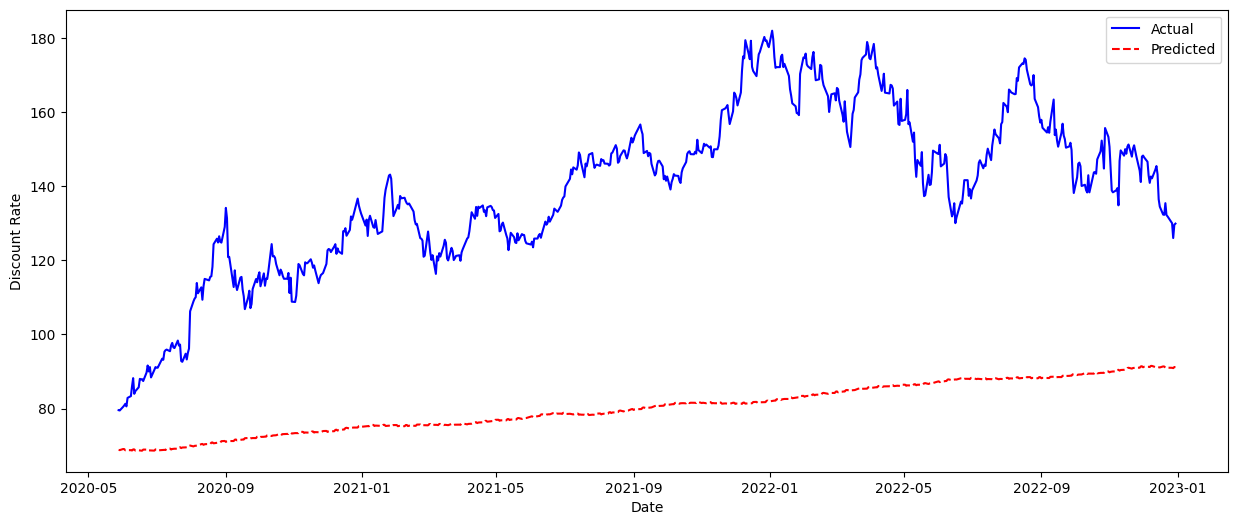

Evaluation Metrics:
Mean Absolute Error (MAE): 58.88
Mean Squared Error (MSE): 3782.02
Root Mean Squared Error (RMSE): 61.50


In [ ]:
# Split the data into training and testing sets
train_size = int(len(ts_data) * 0.8)  # 80% for training, 20% for testing
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]



# Prepare the data for Prophet
train_data_prophet = train_data.reset_index()
train_data_prophet.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(train_data_prophet)

# Forecast on the test set
future = model.make_future_dataframe(periods=len(test_data))
forecast = model.predict(future)

# Extract the predicted values
predictions = forecast['yhat'][train_size:]

plt.figure(figsize=(15,6))
# Visualize the actual values vs. predicted values
plt.plot(test_data.index, test_data['Close'], color='blue', linestyle='-', label='Actual')
plt.plot(test_data.index, predictions, color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Discount Rate')
plt.legend()
plt.show()

# Evaluate the model
mae_3_2 = mean_absolute_error(test_data['Close'], predictions)
mse_3_2 = mean_squared_error(test_data['Close'], predictions)
rmse_3_2 = mean_squared_error(test_data['Close'], predictions, squared=False)

# Display evaluation metrics
print('Evaluation Metrics:')
print(f'Mean Absolute Error (MAE): {mae_3_2:.2f}')
print(f'Mean Squared Error (MSE): {mse_3_2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_3_2:.2f}')




# LSTM

Epoch 1/50
82/82 [==============================] - 4s 6ms/step - loss: 0.0023
Epoch 2/50
82/82 [==============================] - 0s 6ms/step - loss: 6.0327e-05
Epoch 3/50
82/82 [==============================] - 0s 5ms/step - loss: 5.7929e-05
Epoch 4/50
82/82 [==============================] - 0s 6ms/step - loss: 5.4981e-05
Epoch 5/50
82/82 [==============================] - 0s 6ms/step - loss: 5.5012e-05
Epoch 6/50
82/82 [==============================] - 0s 6ms/step - loss: 5.2090e-05
Epoch 7/50
82/82 [==============================] - 0s 5ms/step - loss: 6.3128e-05
Epoch 8/50
82/82 [==============================] - 0s 5ms/step - loss: 6.2309e-05
Epoch 9/50
82/82 [==============================] - 0s 6ms/step - loss: 5.1372e-05
Epoch 10/50
82/82 [==============================] - 0s 6ms/step - loss: 6.3056e-05
Epoch 11/50
82/82 [==============================] - 1s 8ms/step - loss: 5.0554e-05
Epoch 12/50
82/82 [==============================] - 1s 8ms/step - loss: 5.1276e-05
Epoch

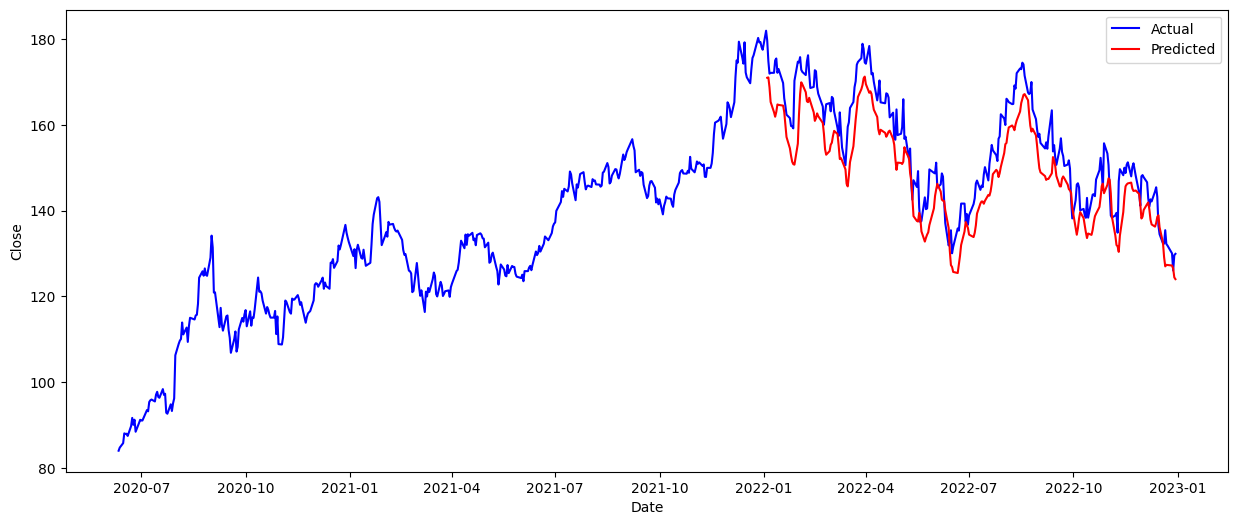

Evaluation Metrics:
Mean Absolute Error (MAE): 5.28
Mean Squared Error (MSE): 38.82
Root Mean Squared Error (RMSE): 6.23


In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training, 20% for testing
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the function to create input and output sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set the sequence length
sequence_length = 10

# Create training sequences
X_train, y_train = create_sequences(train_data, sequence_length)

# Create testing sequences
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Perform predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

plt.figure(figsize=(15,6))
# Visualize the actual values vs. predicted values
plt.plot(ts_data.index[train_size+sequence_length:], y_test, color='blue', label='Actual')
plt.plot(ts_data.index[train_size+sequence_length:][-250:], predictions[-250:], color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Evaluate the model
mae_3_3 = mean_absolute_error(y_test, predictions)
mse_3_3 = mean_squared_error(y_test, predictions)
rmse_3_3 = np.sqrt(mse_3_3)

# Display evaluation metrics
print('Evaluation Metrics:')
print(f'Mean Absolute Error (MAE): {mae_3_3:.2f}')
print(f'Mean Squared Error (MSE): {mse_3_3:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_3_3:.2f}')

In [ ]:
import pandas as pd

# Define the index, column names, and values
columns = ['MSE', 'RMSE', 'MAE']
index = ['SARIMAX', 'Prophet', 'LSTM']
values = [[mse_3_1, rmse_3_1, mae_3_1], [mse_3_2, rmse_3_2, mae_3_2], [mse_3_3, rmse_3_3, mae_3_3]]

# Create the DataFrame
df = pd.DataFrame(values, index=index, columns=columns)

# Define a function to apply styles to specific cells
def style_cells(value):
    style = 'background-color: red' if value > 4 else  'background-color: green'
    return style

# Apply the style to the DataFrame
styled_df = df.style.applymap(style_cells)

# Add lines to the DataFrame
styled_df.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
])

# Display the styled DataFrame
print("The Evaluation trade-off for the Second Dataset : ")
styled_df


The Evaluation trade-off for the Second Dataset : 


,MSE,RMSE,MAE
SARIMAX,4.180719,2.044681,1.296307
Prophet,3782.017309,61.498108,58.879229
LSTM,38.821212,6.230667,5.282454
